# Description of SS - benchmarks deletion

In [1]:
import os
import sys
import csv
import pandas as pd
from tqdm import tqdm
from soma import aims
import numpy as np
import matplotlib.pyplot as plt

import deep_folding as df
from deep_folding.brainvisa.utils.bbox import compute_max_box
from deep_folding.brainvisa.utils.sulcus import complete_sulci_name
from deep_folding.brainvisa.utils.mask import compute_simple_mask

### Simple Surface Size Distribution

In [2]:
data_dir = '/neurospin/dico/data/bv_databases/human/hcp/hcp'
mask_dir = '/neurospin/dico/data/deep_folding/current/mask/1mm/'
_DEFAULT_BBOX_DIR = '/neurospin/dico/data/deep_folding/current/bbox/'

In [3]:
subjects_list = '/neurospin/dico/lguillon/distmap/data/test_list.csv'
subjects_list = pd.read_csv(subjects_list)
subjects_list = list(subjects_list['subjects'])

In [4]:
side = 'R'
sub = '100206'
sulci_list = complete_sulci_name(['S.C.'], side)
mask, bbmin, bbmax = compute_simple_mask(sulci_list, side, mask_dir)

only one sulcus: S.C._right


In [5]:
path_to_graph = "t1mri/BL/default_analysis/folds/3.1/deepcnn_auto"
cpt_arg_1 = 't1mri/default_acquisition/default_analysis/folds/3.1/default_session_auto'
cpt_arg_2 = '_default_session_auto.arg'
voxel_size_out = (1, 1, 1, 1)
ss_size = 200

In [38]:
histo_size = {}

for sub in subjects_list:
    graph_file = f"{data_dir}/{sub}/{path_to_graph}/{side}{sub}_deepcnn_auto.arg"

    if os.path.isdir(os.path.join(data_dir, str(sub) + '/')) and os.path.isfile(graph_file):
        # surfaces = dict()

        graph = aims.read(graph_file)

        g_to_icbm_template = aims.GraphManip.getICBM2009cTemplateTransform(graph)
        voxel_size_in = graph['voxel_size'][:3]

        for v in graph.vertices():
            if 'label' in v:
                bck_map = v['aims_ss']

                # Creation of a volume in ICBM space where to write voxels
                # of the simple surface
                hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
                resampling_ratio = np.array(hdr['voxel_size']) / voxel_size_out
                orig_dim = hdr['volume_dimension']
                new_dim = list((resampling_ratio * orig_dim).astype(int))

                vol = aims.Volume(new_dim, dtype='S16')
                vol.copyHeaderFrom(hdr)
                vol.header()['voxel_size'] = voxel_size_out
                arr = np.asarray(vol)
                # Transformation of SS voxels to ICBM space with voxel_size_out
                voxels_icbm = np.asarray(
                    [g_to_icbm_template.transform(np.array(voxel) * voxel_size_in)
                     for voxel in bck_map[0].keys()])
                voxels = np.round(np.array(voxels_icbm) / voxel_size_out[:3]).astype(int)
                # Writing of the voxels in the created volume
                for i,j,k in voxels:
                    arr[i,j,k,0] = 1
                # Suppression of all voxels out of the mask
                arr[np.array(mask)<1]=0
                # Selection of the ss if a mininum of voxels remains
                size = np.count_nonzero(arr>0)
                if np.count_nonzero(arr>0)>ss_size and np.count_nonzero(arr>0)<500:
                    print(v['label'], bck_map[0].size())
                    print(np.count_nonzero(arr == 1))
                    print(np.count_nonzero(arr>0))
                    # surfaces[len(surfaces)] = v
                    if size in histo_size.keys():
                        histo_size[size] += 1
                    else: 
                         histo_size[size] = 1
    print(histo_size)

F.C.L.p._right 1092
201
201
F.C.L.r.retroC.tr._right 472
219
219
{201: 1, 219: 1}
F.I.P.Po.C.inf._right 966
477
477
{201: 1, 219: 1, 477: 1}
S.Po.C.sup._right 444
326
326
F.I.P.Po.C.inf._right 556
424
424
F.I.P.Po.C.inf._right 328
256
256
F.I.P.Po.C.inf._right 436
322
322
{201: 1, 219: 1, 477: 1, 326: 1, 424: 1, 256: 1, 322: 1}
S.C.sylvian._right 303
214
214


KeyboardInterrupt: 

In [71]:
histo_size = {}
sc_size = {}

dict_sub_size = {'<200':[], '200_500': [], '500_700': [], '700_1000':[], '1000_1500': [], 
                 '1500_2000': [], '>2000': []}

for sub in tqdm(subjects_list):
    sub_size = []
    graph_file = f"{data_dir}/{sub}/{path_to_graph}/{side}{sub}_deepcnn_auto.arg"

    if os.path.isdir(os.path.join(data_dir, str(sub) + '/')) and os.path.isfile(graph_file):
        # surfaces = dict()

        graph = aims.read(graph_file)

        g_to_icbm_template = aims.GraphManip.getICBM2009cTemplateTransform(graph)
        voxel_size_in = graph['voxel_size'][:3]

        for v in graph.vertices():
            if 'label' in v:
                bck_map = v['aims_ss']

                # Creation of a volume in ICBM space where to write voxels
                # of the simple surface
                hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
                resampling_ratio = np.array(hdr['voxel_size']) / voxel_size_out
                orig_dim = hdr['volume_dimension']
                new_dim = list((resampling_ratio * orig_dim).astype(int))

                vol = aims.Volume(new_dim, dtype='S16')
                vol.copyHeaderFrom(hdr)
                vol.header()['voxel_size'] = voxel_size_out
                arr = np.asarray(vol)
                # Transformation of SS voxels to ICBM space with voxel_size_out
                voxels_icbm = np.asarray(
                    [g_to_icbm_template.transform(np.array(voxel) * voxel_size_in)
                     for voxel in bck_map[0].keys()])
                voxels = np.round(np.array(voxels_icbm) / voxel_size_out[:3]).astype(int)
                # Writing of the voxels in the created volume
                for i,j,k in voxels:
                    arr[i,j,k,0] = 1
                # Suppression of all voxels out of the mask
                arr[np.array(mask)<1]=0
                # Selection of the ss if a mininum of voxels remains
                size = np.count_nonzero(arr>0)
                if size>0:
                    #print(size)
#                 if np.count_nonzero(arr>0)>ss_size and np.count_nonzero(arr>0)<500:
#                     print(v['label'], bck_map[0].size())
#                     print(np.count_nonzero(arr == 1))
#                     print(np.count_nonzero(arr>0))
#                     # surfaces[len(surfaces)] = v
                    sub_size.append(size)
                    #print(sub_size)
                    if size in histo_size.keys():
                        #histo_size[size] += 1
                        histo_size[size].append(v['label'])
                    else:
                        #histo_size[size] = 1
                        histo_size[size] = [v['label']]
        sub_size = np.array(sub_size)
        dict_sub_size['<200'].append(np.count_nonzero(sub_size<200))
        dict_sub_size['200_500'].append(np.count_nonzero(np.logical_and(sub_size>=200, sub_size<500)))
        dict_sub_size['500_700'].append(np.count_nonzero(np.logical_and(sub_size>=500, sub_size<700)))
        dict_sub_size['700_1000'].append(np.count_nonzero(np.logical_and(sub_size>=700, sub_size<1000)))
        dict_sub_size['1000_1500'].append(np.count_nonzero(np.logical_and(sub_size>=1000, sub_size<1500)))
        dict_sub_size['1500_2000'].append(np.count_nonzero(np.logical_and(sub_size>=1500, sub_size<2000)))
        dict_sub_size['>2000'].append(np.count_nonzero(sub_size>=2000))

100%|██████████| 200/200 [1:47:43<00:00, 32.32s/it]


In [72]:
{key: histo_size[key] for key in list(np.array(list(histo_size.keys()))[np.array(list(histo_size.keys()))>700]) }

{1226: ['S.C._right'],
 1803: ['S.C._right'],
 1771: ['S.C._right'],
 708: ['S.C._right'],
 2086: ['S.C._right'],
 910: ['S.C._right', 'S.C._right', 'S.C._right'],
 803: ['F.I.P.Po.C.inf._right'],
 925: ['S.C._right', 'S.C._right'],
 953: ['S.C._right', 'S.C._right', 'S.C._right'],
 1724: ['S.C._right'],
 874: ['S.C._right', 'S.C._right'],
 1025: ['S.C._right'],
 958: ['S.C._right'],
 1027: ['S.C._right'],
 1044: ['S.C._right'],
 1117: ['S.C._right'],
 861: ['S.C._right'],
 1164: ['S.C._right'],
 895: ['S.C._right'],
 1789: ['S.C._right'],
 706: ['F.I.P.Po.C.inf._right', 'S.C._right'],
 778: ['F.I.P.Po.C.inf._right'],
 1270: ['S.C._right'],
 834: ['S.C._right'],
 860: ['S.C._right'],
 1827: ['S.C._right'],
 1137: ['S.C._right', 'S.C._right'],
 851: ['S.C._right'],
 1947: ['S.C._right'],
 1040: ['S.C._right'],
 882: ['S.C._right'],
 862: ['S.C._right', 'S.C._right'],
 1375: ['S.C._right'],
 1171: ['S.C._right'],
 760: ['S.C._right'],
 2065: ['S.C._right'],
 1046: ['S.C._right'],
 701: [

In [216]:
sulci = np.unique(list(histo_size.values())[0])
dico_sulci = {sulcus:[] for sulcus in sulci}
for sulcus in sulci:
    for key in histo_size.keys():
        if key>=200:
            if sulcus in histo_size[key]:
                dico_sulci[sulcus].append(key)

In [217]:
main_dico_sulci = {'S.C._right': dico_sulci['S.C._right'],
                   'S.Pe.C': dico_sulci['S.Pe.C.inf._right'] + dico_sulci['S.Pe.C.inter._right'] +
                             dico_sulci['S.Pe.C.marginal._right'] + dico_sulci['S.Pe.C.median._right']+ dico_sulci['S.Pe.C.sup._right'],
                  'S.Po.C': dico_sulci['S.Po.C.sup._right']+ dico_sulci['F.I.P.Po.C.inf._right']}

precentral = ['S.Pe.C.inf._right', 'S.Pe.C.inter._right', 'S.Pe.C.marginal._right', 'S.Pe.C.median._right', 'S.Pe.C.sup._right']
flag_pre = False
postcentral = ['S.Po.C.sup._right', 'F.I.P.Po.C.inf._right']
flag_post = False

for sulcus in sulci:
    if 'S.Pe' in sulcus:
        if flag_pre==False:
            print('S.Pe.C', sum([len(dico_sulci[pre]) for pre in precentral]))
            flag_pre = True
    elif 'Po' in sulcus:
        if flag_post==False:
            print('S.Po.C', sum([len(dico_sulci[post]) for post in postcentral]))
            flag_post = True
    else:
        print(sulcus, len(dico_sulci[sulcus]))

F.C.L.p._right 4
F.C.L.r.retroC.tr._right 13
F.C.M.post._right 19
S.Po.C 229
F.I.P._right 10
S.C._right 305
S.F.sup._right 2
S.Pa.int._right 0
S.Pe.C 72


In [218]:
main_dico_sulci = {'S.C._right': dico_sulci['S.C._right'],
                   'S.Pe.C': dico_sulci['S.Pe.C.inf._right'] + dico_sulci['S.Pe.C.inter._right'] +
                             dico_sulci['S.Pe.C.marginal._right'] + dico_sulci['S.Pe.C.median._right']+ dico_sulci['S.Pe.C.sup._right'],
                  'S.Po.C': dico_sulci['S.Po.C.sup._right']+ dico_sulci['F.I.P.Po.C.inf._right']}

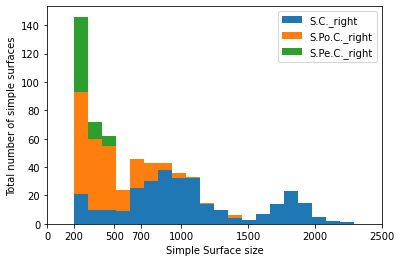

In [221]:
plt.hist([main_dico_sulci['S.C._right'], main_dico_sulci['S.Po.C'], main_dico_sulci['S.Pe.C']], 
         stacked=True,
        label=['S.C._right', 'S.Po.C._right', 'S.Pe.C._right'], bins=20)
plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
plt.xlabel('Simple Surface size')
plt.ylabel('Total number of simple surfaces')
plt.legend()
plt.show()

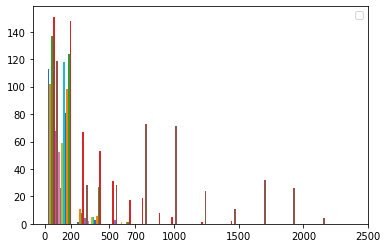

In [158]:
plt.hist([dico_sulci[sulcus] for sulcus in dico_sulci.keys()])
plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
plt.legend()

In [72]:
with open('dict_ss_size_dstrb.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in histo_size.items():
        writer.writerow([key, value])

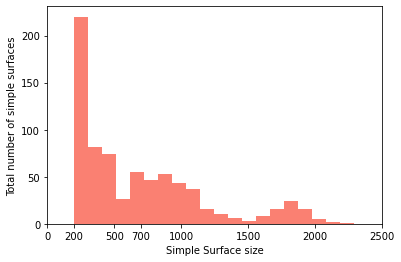

In [215]:
import copy
histo_size_xo_0 = copy.deepcopy(histo_size)
ax1 = plt.subplot()
#del histo_size_xo_0[0]
plt.hist(list_histo, color='salmon', bins=20)
plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
# ax2 = ax1.twinx()

# ax2.errorbar([150, 300, 600, 850, 1250, 1775, 2500],
#             [np.mean(dict_sub_size[key]) for key in dict_sub_size.keys()],
#             yerr=[np.std(dict_sub_size[key]) for key in dict_sub_size.keys()], marker='o')

ax1.set_xlabel('Simple Surface size')
ax1.set_ylabel('Total number of simple surfaces')
ax2.set_ylabel('Average number of simple surfaces')
plt.show()

In [160]:
histo_size_glob = {key: histo_size[key] for key in histo_size.keys()}

In [199]:
list_histo = [key for k in range(len(histo_size[key])) for key in histo_size.keys()]

In [208]:
list_histo = []
for key in histo_size.keys():
    if key>=200:
        for k in range(len(histo_size[key])):
            list_histo.append(key)

In [209]:
len(list_histo)

744

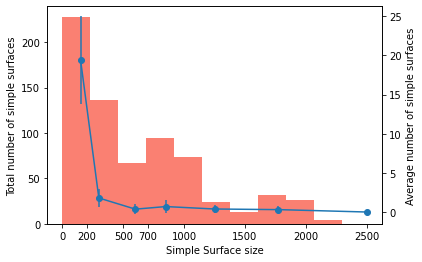

In [152]:
import copy
histo_size_xo_0 = copy.deepcopy(histo_size)
ax1 = plt.subplot()
#del histo_size_xo_0[0]
ax1.hist(histo_size_xo_0, color='salmon')
plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
ax2 = ax1.twinx()

ax2.errorbar([150, 300, 600, 850, 1250, 1775, 2500],
            [np.mean(dict_sub_size[key]) for key in dict_sub_size.keys()],
            yerr=[np.std(dict_sub_size[key]) for key in dict_sub_size.keys()], marker='o')

ax1.set_xlabel('Simple Surface size')
ax1.set_ylabel('Total number of simple surfaces')
ax2.set_ylabel('Average number of simple surfaces')
plt.show()

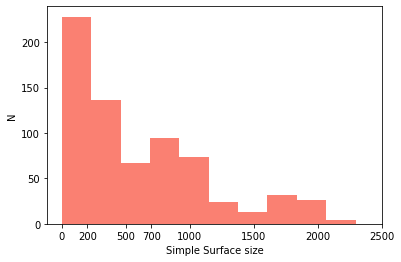

In [82]:
import copy
histo_size_xo_0 = copy.deepcopy(histo_size)

#del histo_size_xo_0[0]
plt.hist(histo_size_xo_0, color='salmon')
plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
plt.xlabel('Simple Surface size')
plt.ylabel('N')
plt.show()

In [ ]:
skel_size = {}

for sub in tqdm(subjects_list):
    total_vox_sub = 0
    
    graph_file = f"{data_dir}/{sub}/{path_to_graph}/{side}{sub}_deepcnn_auto.arg"

    if os.path.isdir(os.path.join(data_dir, str(sub) + '/')) and os.path.isfile(graph_file):
        # surfaces = dict()

        graph = aims.read(graph_file)

        g_to_icbm_template = aims.GraphManip.getICBM2009cTemplateTransform(graph)
        voxel_size_in = graph['voxel_size'][:3]

        for v in graph.vertices():
            if 'label' in v:
                bck_map = v['aims_ss']

                # Creation of a volume in ICBM space where to write voxels
                # of the simple surface
                hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
                resampling_ratio = np.array(hdr['voxel_size']) / voxel_size_out
                orig_dim = hdr['volume_dimension']
                new_dim = list((resampling_ratio * orig_dim).astype(int))

                vol = aims.Volume(new_dim, dtype='S16')
                vol.copyHeaderFrom(hdr)
                vol.header()['voxel_size'] = voxel_size_out
                arr = np.asarray(vol)
                # Transformation of SS voxels to ICBM space with voxel_size_out
                voxels_icbm = np.asarray(
                    [g_to_icbm_template.transform(np.array(voxel) * voxel_size_in)
                     for voxel in bck_map[0].keys()])
                voxels = np.round(np.array(voxels_icbm) / voxel_size_out[:3]).astype(int)
                # Writing of the voxels in the created volume
                for i,j,k in voxels:
                    arr[i,j,k,0] = 1
                # Suppression of all voxels out of the mask
                arr[np.array(mask)<1]=0

                size = np.count_nonzero(arr>0)
                total_vox_sub += size
                
        if total_vox_sub in skel_size.keys():
            skel_size[total_vox_sub] += 1
        else: 
             skel_size[total_vox_sub] = 1

In [ ]:
import csv
with open('dict_skel_size_dstrb.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in skel_size.items():
        writer.writerow([key, value])

In [ ]:
import copy
skel_size_xo_0 = copy.deepcopy(skel_size)

#del skel_size_xo_0[0]
plt.hist(skel_size_xo_0, color='salmon')
# plt.xticks([0, 200, 500, 700, 1000, 1500, 2000, 2500])
plt.xlabel('Number of skeleton voxels')
plt.ylabel('N')
plt.show()